In [30]:
import pandas as pd
import random
import numpy as np
import math
import sys
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import xgboost as xgb
import datatable as dt

from xgboost import plot_tree
from os import walk
from os import listdir
from os.path import isfile, join
from scipy.spatial.distance import euclidean, pdist, squareform
from scipy.stats import skew
from scipy.special import expit as sigmoid
from scipy.cluster.hierarchy import fclusterdata
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import precision_recall_fscore_support
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [31]:
DATA_PATH = "data"

In [32]:
HISTORY_PATH = "Voter_History_{0}"
REGISTRATION_PATH = "Voter_Registration_{0}/{1}_VoterDetail"

In [33]:
date = '20190813'

## Registration Analysis

In [34]:
full_path = "/".join([DATA_PATH, REGISTRATION_PATH.format(str(date), str(date))])

In [35]:
county_files = []
for f in listdir(full_path):
    if isfile(full_path + "/" + f):
        county_files.append(full_path + "/" + f)

In [36]:
county = "DAD"
county_path = ""
for c in county_files:
    if (county + "_") in c:
        county_path = c
        break

In [37]:
county_path

'data/Voter_Registration_20190813/20190813_VoterDetail/DAD_20190813.txt'

In [38]:
registration_file_headers = [
    'county_code',
    'voter_id',
    'last_name',
    'suffix',
    'first_name',
    'middle_name',
    'requested_public_records_exemption',
    'residence_addr_line_1',
    'residence_addr_line_2',
    'residence_city',
    'residence_state',
    'residence_zipcode',
    'mail_addr_line_1',
    'mail_addr_line_2',
    'mail_addr_line_3',
    'mail_city',
    'mail_state',
    'mail_zipcode',
    'mail_country',
    'gender',
    'race',
    'birth_date',
    'registration_date',
    'party_affiliation',
    'precinct',
    'precinct_group',
    'precinct_split',
    'precinct_suffix',
    'voter_status',
    'congressional_district',
    'house_district',
    'senate_district',
    'county_commission_district',
    'school_board_district',
    'daytime_area_code',
    'daytime_phone_no',
    'daytime_phone_extension',
    'email_address'
]

In [39]:
len(registration_file_headers)

38

In [40]:
county_voters_registration_df = dt.fread(county_path, sep='\t', columns=registration_file_headers).to_pandas()

In [41]:
county_voters_registration_df.head()

,county_code,voter_id,last_name,suffix,first_name,middle_name,requested_public_records_exemption,residence_addr_line_1,residence_addr_line_2,residence_city,...,voter_status,congressional_district,house_district,senate_district,county_commission_district,school_board_district,daytime_area_code,daytime_phone_no,daytime_phone_extension,email_address
0,DAD,120685459,Cedeno,,Kristia,Lex Andree Palma,N,3245 Virginia ST,APT 38,Miami,...,ACT,27,112,37,7,6,,,,
1,DAD,117588041,Cade,,Anthony,Dywane,N,16931 SW 100Th PL,,Miami,...,ACT,26,117,40,9,9,,,,
2,DAD,120684443,Felix Estrada,,Rafael,Enrique,N,257 E 4Th ST,APT 207,Hialeah,...,ACT,25,111,36,6,5,,,,
3,DAD,109101127,Tadeo,,Martha,Sarah,N,1145 SW 12Th St,,Miami,...,ACT,27,112,37,5,6,305,8569832,,
4,DAD,109341804,Gonzalez,,Jose,Santiago,N,27881 SW 139Th Ct,,Homestead,...,ACT,26,117,39,9,9,786,2994838,,


In [42]:
county_voters_registration_df.isnull().sum()

county_code                           0
voter_id                              0
last_name                             0
suffix                                0
first_name                            0
middle_name                           0
requested_public_records_exemption    0
residence_addr_line_1                 0
residence_addr_line_2                 0
residence_city                        0
residence_state                       0
residence_zipcode                     0
mail_addr_line_1                      0
mail_addr_line_2                      0
mail_addr_line_3                      0
mail_city                             0
mail_state                            0
mail_zipcode                          0
mail_country                          0
gender                                0
race                                  0
birth_date                            0
registration_date                     0
party_affiliation                     0
precinct                              0


In [43]:
null_columns = county_voters_registration_df.columns[county_voters_registration_df.isnull().any()].tolist()
non_null_columns = list(set(county_voters_registration_df.columns) - set(null_columns))

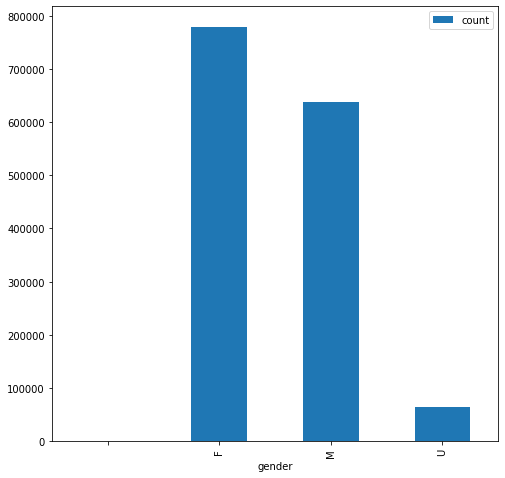

In [44]:
figures, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
county_voters_registration_df.groupby(['gender'])['voter_id'].agg(['count']).plot(kind='bar', ax=axes)

In [45]:
last_name_freq = county_voters_registration_df.groupby(['last_name'])['voter_id'].agg(['count']).reset_index()

In [46]:
top_10_freq_last_name = last_name_freq.sort_values(by='count', ascending=False)[:10]

In [47]:
county_voters_registration_df['unique_addr'] = county_voters_registration_df[['residence_addr_line_1', 'residence_addr_line_2', 'residence_city']].apply(lambda x: ' '.join(x), axis=1).str.lower()

In [48]:
county_voters_registration_df['unique_addr']

0               3245   virginia st apt 38 miami
1                     16931  sw 100th pl  miami
2                 257  e 4th st apt 207 hialeah
3                       1145  sw 12th st  miami
4                 27881  sw 139th ct  homestead
                           ...                 
1480009            1046  ne 17th ter  homestead
1480010    1100   brickell bay dr apt 37c miami
1480011              3639  ne 2nd ct  homestead
1480012               14930  sw 141st pl  miami
1480013                15480  sw 31st ln  miami
Name: unique_addr, Length: 1480014, dtype: object

In [49]:
county_voters_registration_df['unique_addr'].value_counts()[:10]

2700  nw 87th ave  doral             4020
* * *                                3435
2700 d nw 87th ave  doral            1737
2700 c nw 87th ave  doral             553
2700 f nw 87th ave  doral             547
2700 g nw 87th ave  doral             420
15800  nw 42nd ave  miami gardens     395
2700 e nw 87th ave  doral             271
1603  nw 7th ave  miami               240
1550  n miami ave  miami              201
Name: unique_addr, dtype: int64

In [54]:
top_ten_cities = county_voters_registration_df.residence_city.value_counts()[:5].index.to_list()

In [55]:
top_ten_cities_df = county_voters_registration_df[county_voters_registration_df.residence_city.isin(top_ten_cities)]

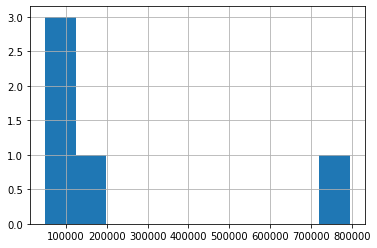

In [56]:
county_voters_registration_df[county_voters_registration_df.residence_city.isin(top_ten_cities)].groupby(['residence_city'])['party_affiliation'].count().hist()

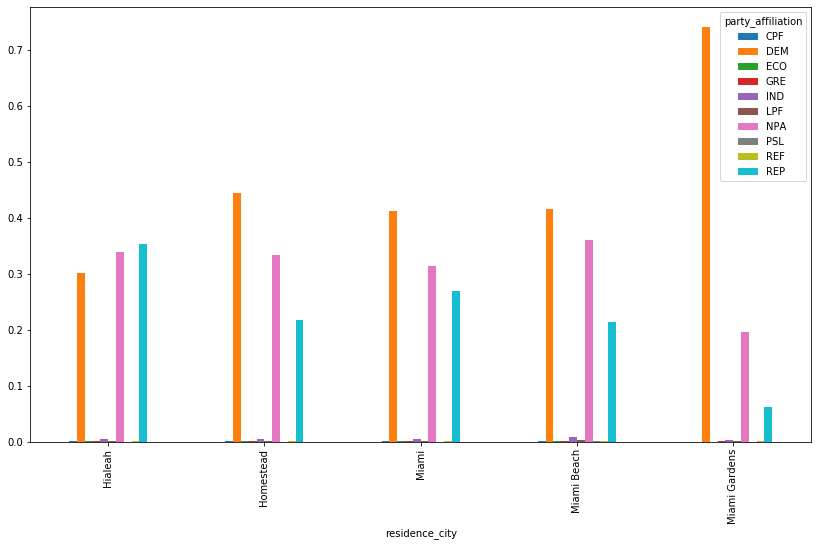

In [57]:
fig, ax = plt.subplots(figsize=(14,8))
pd.crosstab(top_ten_cities_df['residence_city'], top_ten_cities_df['party_affiliation']).apply(lambda r: r/r.sum(), axis=1).plot(kind='bar', ax=ax)
plt.savefig('citywise_affiliation.png')

In [58]:
party_counts = county_voters_registration_df.party_affiliation.value_counts().reset_index()

In [59]:
party_counts = party_counts.append({'index': 'Others', 'party_affiliation': party_counts[3:].sum()['party_affiliation']}, ignore_index=True).sort_values(by='party_affiliation',ascending=False)

In [60]:
party_counts = party_counts[:4]

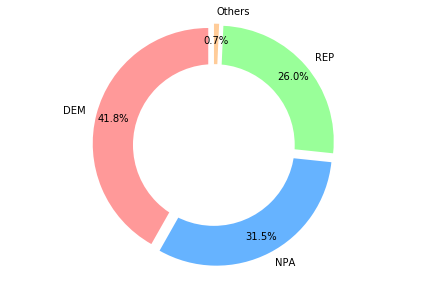

In [62]:
labels = party_counts['index']
sizes = party_counts.party_affiliation

#explsion
explode = (0.05,0.05,0.05,0.05)

#colors
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

plt.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  
plt.tight_layout()
plt.savefig("political_affiliations.png")

In [63]:
party_counts

,index,party_affiliation
0,DEM,618675
1,NPA,466649
2,REP,384136
10,Others,10554
